## Visualize the decision of the classifier

## Imports

* torch for tensor manipulation
* torchvision for resnet18
* transforms for Normalization
* pytorch lightning for model creation
* numpy for data loading
* matplotlib for plotting

In [1]:
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

The dataset of the previous notebook is used.

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)


In [3]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248),

])

val_dataset = torchvision.datasets.DatasetFolder("Processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

The key idea of CAM is to multiply the output of the last convolutional layer (BasicBlock 1 of layer 4) $A_k$ (consisting of k channels) with the parameters $w$ of the subsequent fully connected layer to compute an activation map $M$:
$$ M = \sum_k w_kA_k$$

To do so, we need to access this particular output of the trained resnet18.<br />
Let's recap the resnet architecture:

In [4]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can convert the network to a generator using the **children()** function.<br />
This means that we can use the list function to convert it into a list!<br />
The convolutional part of the network comprises all layers up to the AdaptiveAvgPool2d layer.

In [5]:
list(temp_model.children())[:-2]  # get all layers up to avgpool

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

Using **Sequential** from pytorch, we convert the list of layers back to a Sequential Model.


In [6]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Now we are ready to go.<br />
We add an additional output to the forward function of our pneumonia model, to return the feature maps of the last convolutional layer ($A$)

We extract the feature map in the forward pass, followed by global average pooling and flattening.
Finally we use the fully connected layer to compute the final class prediction.

In [7]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    
    def forward(self, data):
        
        # Compute feature map
        feature_map = self.feature_map(data)
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map
    


In [8]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [9]:
# Use strict to prevent pytorch from loading weights for self.feature_map
model = PneumoniaModel.load_from_checkpoint("weights/weights_3.ckpt", strict=False)
model.eval();

/Users/divyanshagarwal/Desktop/Desktop - mac maybe/git_repos/medical_imaging/venv/lib/python3.13/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint weights/weights_3.ckpt`
/Users/divyanshagarwal/Desktop/Desktop - mac maybe/git_repos/medical_imaging/venv/lib/python3.13/site-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_m

## CAM
Now we can define the CAM function by using the formula from above:

In [10]:
def cam(model, img):
    """
    Compute class activation map according to cam algorithm
    """
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape

    # We reshape the 512x7x7 feature tensor into a 512x49 tensor in order to simplify the multiplication
    features = features.reshape((c, h*w))
    
    # Get only the weights, not the bias
    weight_params = list(model.model.fc.parameters())[0] 
    
    # Remove gradient information from weight parameters to enable numpy conversion
    weight = weight_params[0].detach()
    print(weight.shape)
    # Compute multiplication between weight and features with the formula from above.
    # We use matmul because it directly multiplies each filter with the weights
    # and then computes the sum. This yields a vector of 49 (7x7 elements)
    cam = torch.matmul(weight, features)
    print(features.shape)
    
    ### The following loop performs the same operations in a less optimized way
    #cam = torch.zeros((7 * 7))
    #for i in range(len(cam)):
    #    cam[i] = torch.sum(weight*features[:,i])
    ##################################################################
    
    # Normalize and standardize the class activation map (Not always necessary, thus not shown in the lecture)
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    # Reshape the class activation map to 512x7x7 and move the tensor back to CPU
    cam_img = cam_img.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)

def visualize(img, heatmap, pred):
    """
    Visualization function for class activation maps
    """
    img = img[0]
    # Resize the activation map of size 7x7 to the original image size (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]
    
    # Create a figure
    fig, axis = plt.subplots(1, 2)
    
    axis[0].imshow(img, cmap="bone")
    # Overlay the original image with the upscaled class activation map
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    plt.title(f"Pneumonia: {(pred > 0.5).item()}")

In [11]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred)

## Demo Time

In [12]:
img = val_dataset[-6][0]  # Select a subject
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 49])


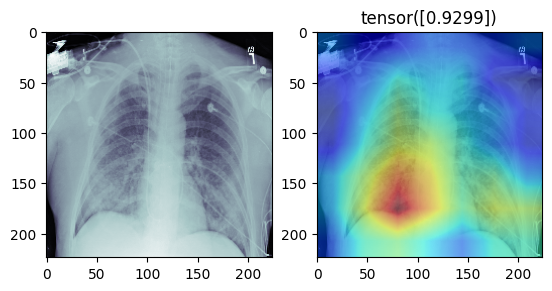

In [13]:
visualize(img, activation_map, pred)  # Visualize CAM

The heatmap focuses on the area which shows signs of pneumonia, isn't that cool?